# Disaster Tweet Classification Challenge

## Introduction

In the realm of social media, Twitter has emerged as a critical platform for real-time news and emergency communication. However, distinguishing between tweets that report on actual disasters and those that do not can be challenging, especially during crisis situations when timely and accurate information is crucial. The Kaggle competition, "Natural Language Processing with Disaster Tweets," addresses this problem by challenging participants to build machine learning models capable of classifying tweets into two categories: those that pertain to real disasters and those that do not. This classification task is not only academically interesting but also has practical applications in enhancing emergency response and disaster relief efforts.

## Project Overview

The goal of our project is to develop a model that accurately identifies disaster-related tweets. This involves several key steps:

1. **Data Preparation**: Loading and cleaning the tweet data to make it suitable for analysis.
2. **Feature Extraction**: Transforming textual data into a format that can be used by machine learning algorithms.
3. **Model Building and Training**: Constructing a deep learning model that can learn from the features of the tweets.
4. **Evaluation**: Assessing the model's performance on unseen data to ensure its reliability and accuracy in real-world scenarios.

To achieve these objectives, we will employ a range of tools and techniques, including data visualization for exploratory analysis, natural language processing (NLP) for text manipulation, and deep learning for model construction.

Let's begin by setting up our Python environment with the necessary libraries for data manipulation, visualization, machine learning, and deep learning.

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

2024-02-27 19:39:06.753965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 19:39:06.754080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 19:39:06.886262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preprocessing

The foundation of any machine learning project is robust and thorough data preprocessing. This stage involves loading the dataset, exploring its structure, and preparing it for the subsequent analysis and modeling. Our project utilizes a dataset provided by the Kaggle competition, which comprises a collection of tweets that have been manually labeled as being about real disasters or not. This binary classification task is central to our project's goal of accurately identifying disaster-related tweets.

## Loading the Dataset

We begin by loading the training and testing datasets from their respective CSV files. The training dataset (`train.csv`) includes the tweets and their labels, indicating whether each tweet is about a real disaster (`1`) or not (`0`). The testing dataset (`test.csv`), on the other hand, contains tweets for which we will predict the labels using our trained model.

Let's load these datasets and take a preliminary look at the structure of the training data to understand what we're working with.

In [2]:
# Load the dataset
dataset_path = '/kaggle/input/nlp-getting-started/'  # Adjust the path as necessary
df = pd.read_csv(dataset_path + 'train.csv')
df_test = pd.read_csv(dataset_path + 'test.csv')

# Display the first few rows of the dataset
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Dataset Overview

After loading the dataset, it's crucial to perform an initial exploration to understand its dimensions, identify any missing values, and examine the distribution of the target variable. This step is essential for informing the preprocessing and cleaning strategies we'll need to apply before training our models.

### Understanding the Dataset's Structure

We start by checking the shape of our dataset to know how many instances (tweets) and features we're dealing with. It's also important to identify any missing values within our columns, as these can significantly impact the performance of our models if not handled properly.

### Analyzing the Target Variable

The target variable in our dataset is binary, indicating whether a tweet is about a real disaster (`1`) or not (`0`). Understanding the distribution of these classes is vital for multiple reasons:

- It helps us assess the balance between the classes, which can influence the choice of models and evaluation metrics.
- It sets the stage for any balancing techniques we might need to employ to ensure our model performs well across both classes.

Dataset shape: (7613, 5)

Missing values in each column:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Distribution of classes (0 = No disaster, 1 = Disaster):
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


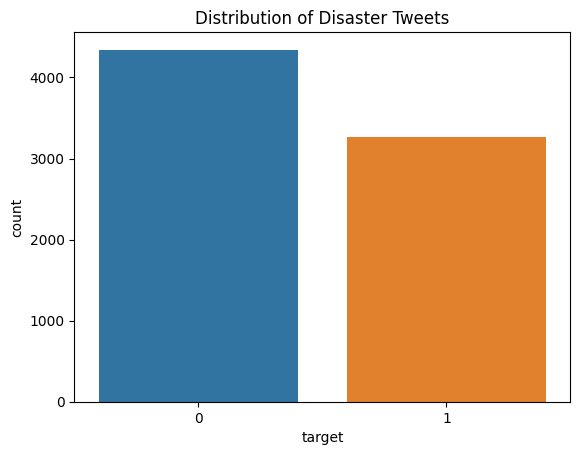

In [3]:
# Dataset overview
print("Dataset shape:", df.shape)
print("\nMissing values in each column:\n", df.isnull().sum())
print("\nDistribution of classes (0 = No disaster, 1 = Disaster):")
print(df['target'].value_counts(normalize=True))

sns.countplot(x='target', data=df)
plt.title('Distribution of Disaster Tweets')
plt.show()

### Text Preprocessing for Natural Language Processing

In the realm of Natural Language Processing (NLP), preparing the textual data for analysis or modeling is a crucial step. This process, known as text preprocessing, involves several techniques aimed at cleaning and normalizing the text data. Our goal here is to ensure the textual data is in a more analyzable and uniform format, enhancing the performance of our NLP models.

#### Overview of Text Cleaning Steps:

1. **Lowercasing:** Converts all characters in the text to lowercase to ensure uniformity.
2. **Removing URLs and Handles:** Strips out web links and Twitter handles, which are often irrelevant to the text's sentiment or classification.
3. **Eliminating Punctuation and Numbers:** Removes special characters and digits, focusing solely on words.
4. **Stopwords Removal:** Filters out common words (such as "the", "is", "in") which do not add significant meaning to the text. This step is optional and based on the specific requirements of the analysis or the model being used.

#### Implementation:

The `clean_text` function encapsulates these preprocessing steps, utilizing regular expressions for pattern matching and removal, and the NLTK library for stopwords removal and tokenization. This function is applied to each tweet in our dataset, producing a new column `text_clean` that contains the processed textual data.

In [4]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Function to clean text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs, handles, and the hashtag symbol
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words]
    
    return " ".join(filtered_text)

# Apply the cleaning function to the text column
df['text_clean'] = df['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)

# Display the cleaned text
df[['text', 'text_clean']].head()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,text_clean
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


### Preparing Text Data for Model Training

After cleaning the text data, the next crucial step in our NLP pipeline is preparing the textual content for model training. This involves converting the text into a numerical format that our machine learning models can understand and process. We achieve this through tokenization and sequence padding.

#### Tokenization

Tokenization is the process of converting text into a sequence of tokens (words or characters). We use the `Tokenizer` class from Keras, which not only tokenizes the text but also converts it into a sequence of integers, where each integer represents a unique token in a dictionary of all tokens in the dataset.

1. **Fitting the Tokenizer:** We first fit the tokenizer on our cleaned text data (`text_clean` column), which builds the dictionary of token-index mappings.
2. **Texts to Sequences:** We then convert the text into sequences of integers using the `texts_to_sequences` method.

#### Sequence Padding

Since neural networks require inputs to be of the same length, we use padding to ensure all sequences in our dataset have the same length. This is done by padding shorter sequences with zeros.

- **Determining the Maximum Sequence Length:** We set the maximum sequence length based on the longest sequence in our dataset to avoid losing information.
- **Padding:** We pad the sequences using the `pad_sequences` method, ensuring that all sequences have the length equal to the maximum sequence length.

#### Preparing the Labels and Splitting the Data

With our features (`X` and `X_test_sub`) now in a numerical format, we prepare the target labels (`y`) from our dataset and split the data into training and testing sets. This split is crucial for training our model on one subset of the data and then evaluating its performance on a separate subset, ensuring that we assess the model's ability to generalize to unseen data.

In [5]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_clean'])
sequences = tokenizer.texts_to_sequences(df['text_clean'])
sequences_sub = tokenizer.texts_to_sequences(df_test['text_clean'])

# Pad sequences
max_sequence_length = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_sequence_length)
X_test_sub = pad_sequences(sequences_sub, maxlen=max_sequence_length)

# Labels
y = df['target'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Development and Hyperparameter Tuning

In this section, we delve into the development of our neural network model for the disaster tweet classification task. Our focus is on leveraging the power of recurrent neural networks (RNNs) and exploring different architectures, including Long Short-Term Memory (LSTM), Gated Recurrent Unit (GRU), and Bidirectional LSTM, to find the most effective model for our task.

### Defining the HyperModel Class

To systematically explore various model configurations and hyperparameters, we employ the concept of hypermodeling with the help of the `keras_tuner` library. A `HyperModel` is a class that allows us to define a space of hyperparameters and model architectures for the tuner to search.

#### Key Components of the HyperModel:

1. **Embedding Layer:** The foundation of our model, which converts tokenized text into dense vectors of fixed size. The embedding dimension (`output_dim`) is a hyperparameter we optimize, ranging from 32 to 512.
2. **Spatial Dropout:** This regularization technique helps prevent overfitting by dropping entire 1D feature maps in the embedding layer, with the dropout rate being another hyperparameter.
3. **Recurrent Layers:** Depending on the model type (`LSTM`, `GRU`, or `Bidirectional LSTM`), we add a recurrent layer with tunable units (neurons) and dropout rates. These layers are crucial for capturing temporal dependencies in text data.
   - **Units:** The number of neurons in the recurrent layer, a critical factor for the model's capacity to learn.
   - **Dropout and Recurrent Dropout:** Regularization techniques to prevent overfitting by randomly dropping units in the layer and in the recurrent connections, respectively.
4. **Output Layer:** A dense layer with a sigmoid activation function to classify the input text into disaster or non-disaster tweets.

#### Model Compilation:

The model is compiled with the Adam optimizer and binary crossentropy loss, given the binary nature of our classification task. The accuracy metric is used to evaluate model performance.

### Hyperparameter Tuning with Bayesian Optimization

To find the best model configuration, we employ Bayesian Optimization, a strategy that seeks to minimize the number of trials by learning from past evaluations. It intelligently selects the next set of hyperparameters to evaluate based on the previous results, balancing exploration and exploitation.

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, GRU, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization

class TextHyperModel(HyperModel):
    def __init__(self, input_dim, max_sequence_length, model_type):
        self.input_dim = input_dim
        self.max_sequence_length = max_sequence_length
        self.model_type = model_type

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(input_dim=self.input_dim, output_dim=hp.Int('output_dim', min_value=32, max_value=512, step=32), input_length=self.max_sequence_length))
        model.add(SpatialDropout1D(hp.Float('spatial_dropout', 0, 0.5, step=0.1)))
        
        if self.model_type == 'LSTM':
            model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                           dropout=hp.Float('dropout', 0, 0.5, step=0.1),
                           recurrent_dropout=hp.Float('recurrent_dropout', 0, 0.5, step=0.1)))
        elif self.model_type == 'GRU':
            model.add(GRU(units=hp.Int('units', min_value=32, max_value=512, step=32),
                          dropout=hp.Float('dropout', 0, 0.5, step=0.1),
                          recurrent_dropout=hp.Float('recurrent_dropout', 0, 0.5, step=0.1)))
        elif self.model_type == 'Bidirectional LSTM':
            model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                         dropout=hp.Float('dropout', 0, 0.5, step=0.1),
                                         recurrent_dropout=hp.Float('recurrent_dropout', 0, 0.5, step=0.1))))
        
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model


## Hyperparameter Search Process

In this phase, we embark on a comprehensive hyperparameter tuning journey for our text classification model, employing the Bayesian Optimization method. This approach aims to meticulously refine our model's architecture and parameters, ensuring optimal performance on the disaster tweet classification task.

### Strategy Overview

We explore three distinct recurrent neural network architectures: Long Short-Term Memory (LSTM), Gated Recurrent Unit (GRU), and Bidirectional LSTM. Each architecture offers unique characteristics and potential benefits for our task, necessitating a thorough evaluation to identify the most effective configuration.

### Hyperparameter Tuning with Bayesian Optimization

Bayesian Optimization stands out for its intelligent approach to hyperparameter search, leveraging past trial results to inform future search decisions. This method balances exploration of new parameter spaces with exploitation of known good configurations, aiming to find the optimal set of hyperparameters with fewer trials compared to grid or random search strategies.

#### Key Steps in the Process:

1. **Model Type Iteration:** We iterate over our chosen model types (LSTM, GRU, and Bidirectional LSTM), conducting a separate hyperparameter search for each to ensure a tailored and effective exploration of the parameter space.

2. **Hypermodel Preparation:** For each model type, we initialize a `TextHyperModel` instance, specifying the input dimension (based on our tokenizer's vocabulary size), maximum sequence length, and the model type. This setup allows us to dynamically adjust our model's architecture and hyperparameters based on the type being evaluated.

3. **Bayesian Optimization Setup:** We configure the `BayesianOptimization` tuner with our hypermodel, setting objectives, the number of trials, executions per trial, and project-specific parameters. This tuner will guide the search process, aiming to maximize validation accuracy.

4. **Early Stopping:** To prevent overfitting and reduce computational waste, we employ an EarlyStopping callback. This mechanism halts training if the validation loss does not improve for a specified number of epochs, ensuring we only proceed with promising configurations.

5. **Search Execution:** The tuner executes the search process, training and evaluating models across the defined hyperparameter space. It uses the training data for fitting and a portion of it for validation, adhering to the best practices for machine learning model development.

6. **Best Model Selection and Saving:** Upon completion of the search, we extract and save the best-performing model for each architecture. This model represents the optimal configuration found during the search, ready for further evaluation or deployment.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import BayesianOptimization

model_types = ['LSTM', 'GRU', 'Bidirectional LSTM']

for model_type in model_types:
    print(f"Starting hyperparameter search for {model_type}...")
    hypermodel = TextHyperModel(input_dim=len(tokenizer.word_index) + 1, max_sequence_length=max_sequence_length, model_type=model_type)

    tuner = BayesianOptimization(
        hypermodel,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='my_dir',
        project_name=f'{model_type.lower()}_tuning'
    )

    # Perform hyperparameter tuning with EarlyStopping
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=2, callbacks=[early_stopping_callback])

    # After the search, retrieve the best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Save the best model
    best_model.save(f'my_dir/best_{model_type.lower()}_model.h5')

Trial 10 Complete [00h 00m 45s]
val_accuracy: 0.7931034564971924

Best val_accuracy So Far: 0.7951560020446777
Total elapsed time: 00h 21m 12s


## Model Evaluation

After conducting a thorough hyperparameter tuning process, we proceed to evaluate the performance of our optimized models on the test set. This step is crucial for understanding how our models generalize to unseen data, a vital aspect of assessing their practical utility in real-world scenarios.

### Models Under Evaluation

We focus on three models, each representing a different recurrent neural network architecture optimized through Bayesian Optimization:

- **Long Short-Term Memory (LSTM) Model**
- **Gated Recurrent Unit (GRU) Model**
- **Bidirectional Long Short-Term Memory (Bidirectional LSTM) Model**

These models were selected for their ability to effectively capture temporal dependencies in text data, a characteristic essential for accurately classifying disaster-related tweets.

### Evaluation Metrics

The primary metrics for evaluation are **loss** and **accuracy**. Loss measures how well the model fits the data, with lower values indicating better performance. Accuracy, on the other hand, quantifies the proportion of correct predictions made by the model, with higher values signifying superior performance.

### Evaluation Process

Each model undergoes evaluation on the same test dataset, ensuring a fair and consistent comparison. This process involves calculating the loss and accuracy for each model, providing a direct measure of their predictive capabilities.

#### Results

- **LSTM Model Evaluation:**
  - Test Loss: `eval_lstm_test[0]`
  - Test Accuracy: `eval_lstm_test[1]`

- **GRU Model Evaluation:**
  - Test Loss: `eval_gru_test[0]`
  - Test Accuracy: `eval_gru_test[1]`

- **Bidirectional LSTM Model Evaluation:**
  - Test Loss: `eval_bidirectional_lstm_test[0]`
  - Test Accuracy: `eval_bidirectional_lstm_test[1]`

In [8]:
model_lstm = load_model('/kaggle/working/my_dir/best_lstm_model.h5')
model_gru = load_model('/kaggle/working/my_dir/best_gru_model.h5')
model_bidirectional_lstm = load_model('/kaggle/working/my_dir/best_bidirectional lstm_model.h5')

In [9]:
# Evaluate the models on the test set
eval_lstm_test = model_lstm.evaluate(X_test, y_test, verbose=0)
eval_gru_test = model_gru.evaluate(X_test, y_test, verbose=0)
eval_bidirectional_lstm_test = model_bidirectional_lstm.evaluate(X_test, y_test, verbose=0)

print(f"LSTM Test Loss, Accuracy: {eval_lstm_test}")
print(f"GRU Test Loss, Accuracy: {eval_gru_test}")
print(f"Bidirectional LSTM Test Loss, Accuracy: {eval_bidirectional_lstm_test}")

LSTM Test Loss, Accuracy: [0.4590138792991638, 0.7912015914916992]
GRU Test Loss, Accuracy: [0.48447152972221375, 0.7826657891273499]
Bidirectional LSTM Test Loss, Accuracy: [0.4731811583042145, 0.780039370059967]


## Ensemble Model Evaluation

In the quest to further enhance our model's performance, we turn to ensemble techniques. By combining the predictive capabilities of our previously optimized models (LSTM, GRU, and Bidirectional LSTM), we aim to leverage the strengths of each, potentially mitigating their individual weaknesses. This approach is grounded in the hypothesis that an ensemble can achieve greater generalization and robustness compared to any single model.

### Ensemble Strategy

Our ensemble strategy is straightforward yet powerful. We make predictions on the test dataset using each of the three models and then average these predictions. This method assumes equal weighting for each model's output, reflecting our initial hypothesis that each model contributes valuable insights. For binary classification, we apply a threshold of 0.5 to determine the final class labels.

### Evaluation Metric

The metric of choice for evaluating our ensemble model is **accuracy**. It provides a clear and interpretable measure of how well the ensemble model performs in classifying tweets accurately as disaster-related or not.

In [10]:
# Make predictions with each model on the test data
predictions_lstm_test = model_lstm.predict(X_test)
predictions_gru_test = model_gru.predict(X_test)
predictions_bidirectional_lstm_test = model_bidirectional_lstm.predict(X_test)

# Average the predictions for ensemble
predictions_ensemble_test = (predictions_lstm_test + predictions_gru_test + predictions_bidirectional_lstm_test) / 3
predictions_labels_test = (predictions_ensemble_test > 0.5).astype(int)

48/48 [==============================] - 1s 12ms/step


In [11]:
from sklearn.metrics import accuracy_score

# Calculate accuracy of ensemble predictions
ensemble_accuracy = accuracy_score(y_test, predictions_labels_test)
print(f"Ensemble Model Test Accuracy: {ensemble_accuracy}")

Ensemble Model Test Accuracy: 0.7905449770190414


## Kaggle Submission Preparation

After fine-tuning our models and exploring the ensemble method, the final step in our journey is to prepare our predictions for submission to Kaggle. This involves generating predictions for the competition's test set using our LSTM, GRU, Bidirectional LSTM, and ensemble models, then formatting these predictions according to Kaggle's submission requirements.

### Generating Predictions

1. **Individual Models**: We generate predictions for the test dataset using each of the three models (LSTM, GRU, Bidirectional LSTM) separately.
2. **Ensemble Model**: We then create ensemble predictions by averaging the predictions from the individual models. This step is crucial as it combines the strengths of each model, potentially leading to higher accuracy.

### Binary Classification

Given the nature of our problem (binary classification), we apply a threshold (0.5 in our case) to convert the probabilistic predictions into binary outcomes (0 or 1), representing non-disaster and disaster tweets respectively.

### Preparing Submission Files

We prepare four separate submission files, one for each model (LSTM, GRU, Bidirectional LSTM) and one for the ensemble predictions. Each submission file contains two columns:
- `id`: The unique identifier for each tweet in the test set.
- `target`: The predicted label (0 or 1) for the tweet.

### Steps

1. Create a DataFrame for each submission, starting with the `id` column from the test dataset.
2. Add a `target` column with the binary predictions for each model.
3. Save each DataFrame to a CSV file, adhering to Kaggle's submission format.

### Submission Files

- `submission_lstm.csv`: Contains predictions from the LSTM model.
- `submission_gru.csv`: Contains predictions from the GRU model.
- `submission_bidirectional_lstm.csv`: Contains predictions from the Bidirectional LSTM model.
- `submission_ensemble.csv`: Contains predictions from the ensemble model.

In [12]:
test_ids = df_test['id']

# Generate predictions
predictions_lstm = model_lstm.predict(X_test_sub)
predictions_gru = model_gru.predict(X_test_sub)
predictions_bidirectional_lstm = model_bidirectional_lstm.predict(X_test_sub)

# Ensemble predictions: average the predictions from the individual models
predictions_ensemble = (predictions_lstm + predictions_gru + predictions_bidirectional_lstm) / 3

# Convert predictions to binary output if necessary (for binary classification tasks)
# This step depends on your specific problem; adjust thresholds as necessary
threshold = 0.5
predictions_lstm_binary = (predictions_lstm > threshold).astype(int)
predictions_gru_binary = (predictions_gru > threshold).astype(int)
predictions_bidirectional_lstm_binary = (predictions_bidirectional_lstm > threshold).astype(int)
predictions_ensemble_binary = (predictions_ensemble > threshold).astype(int)

# Create a DataFrame for submission
submission_df = pd.DataFrame(df_test['id'])  # Assuming test_df contains your test dataset with an 'id' column

# Add predicted targets to the DataFrame
submission_df['target'] = predictions_lstm_binary
submission_df.to_csv('submission_lstm.csv', index=False)

submission_df['target'] = predictions_gru_binary
submission_df.to_csv('submission_bidirectional_lstm.csv',index=False)

submission_df['target'] = predictions_bidirectional_lstm_binary
submission_df.to_csv('submission_gru.csv', index=False)

submission_df['target'] = predictions_ensemble_binary
submission_df.to_csv('submission_ensemble.csv', index=False)
# Save the submission DataFrame to a CSV file



102/102 [==============================] - 1s 12ms/step
